In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/spam_classification

In [ ]:
! pip install langdetect

# SMS 스팸 분류 모델

## 프로그램 장점

1. 2개 언어 지원(영어, 한국어)
2. 혼합 텍스트(영어, 한국어) 분류 가능
3. 모바일 이식 가능(경량화 모델 사용)

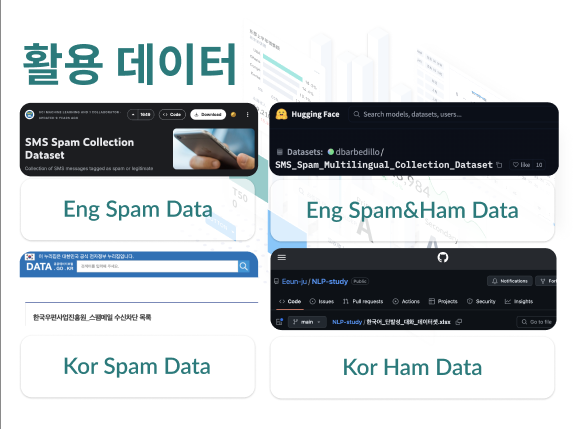

total: 51,806

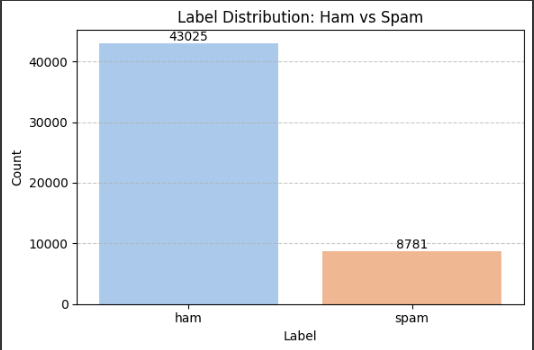

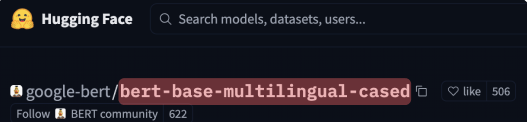

선정 이유:
다국어 지원,
모바일 AI 모델 google/mobilebert-uncased Distillation 가능

# 성능 비교

1. 전처리 과정  X (결측 값, 중복 값 처리)
2. 전처리 과정 0 (언어 감지 패키지 활용 X,
오버샘플링 4000, 다운샘플링 8000)
3. 전처리 과정 0 (언어 감지 패키지 활용 0,
오버샘플링 4000, 다운샘플링 8000) + 단문 필터링

🔍 최종 학습용 샘플 수: 18688

Train
label_str

ham     10134

spam     8554

Name: count, dtype: int64.



Test
label_str
ham	    10757

spam	2195

**total: 31,640**

## 2. 언어 감지 패키지

언어 감지 및 분기 처리(Multilingual-aware Preprocessing): 다국어 환경에서 스팸 탐지 성능을 향상시키기 위한 전략 특히 한국어와 영어가 혼합된 메시지에서는 언어별로 다른 전처리 및 토크나이저를 적용하는 것이 효과적임.  
🔗 논문 원문
* A survey of spam detection techniques in social media
https://www.sciencedirect.com/science/article/abs/pii/S0306457316300966

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import re
from langdetect import detect

# 모델과 토크나이저 로드
model_path = "0608_final_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # 평가모드

In [ ]:
import re
import torch

# 1. 문자 기반 언어 비율 감지 함수
def detect_language_ratio(text):
    """
    텍스트 내 한글/영문 문자 비율을 계산하여 언어를 'korean', 'english', 'mixed'로 분류
    """
    kor = sum(1 for c in str(text) if '\uac00' <= c <= '\ud7a3')  # 한글 글자 개수
    eng = sum(1 for c in str(text) if c.isalpha() and c.isascii())  # 영문 알파벳 개수
    total = kor + eng
    if total == 0:
        return "unknown"
    ratio_kor = kor / total
    ratio_eng = eng / total
    if ratio_kor >= 0.6:
        return "korean"
    elif ratio_eng >= 0.6:
        return "english"
    return "mixed"  # 명확히 비율이 갈리지 않는 경우 혼합

# 2. 영어 전처리 함수
def clean_english_text(text):
    """
    영어 전용 정제 함수: 소문자 변환, 링크/숫자/기호 제거 등
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "<link>", text)  # 링크 마스킹
    text = re.sub(r"\$\d+|\d+\$", "<money>", text)  # 화폐 금액 마스킹
    text = re.sub(r"\d+", "<num>", text)  # 숫자 마스킹
    text = re.sub(r"[^\w\s]", "", text)  # 특수문자 제거
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 3. 한국어 전처리 함수
def clean_korean_text(text):
    """
    한국어 전용 정제 함수: 특수문자 제거, 공백 정리
    """
    text = str(text)
    text = re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9\s]", "", text)  # 한글, 영문, 숫자 제외한 문자 제거
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 4. 혼합 언어 전처리 함수
def clean_mixed_text(text):
    """
    혼합 언어(한영) 정제 함수: 링크/숫자/기호 마스킹 후 한글+영어+숫자만 유지
    """
    text = str(text)
    text = re.sub(r"http\S+|www\S+", "<link>", text)
    text = re.sub(r"\$\d+|\d+\$", "<money>", text)
    text = re.sub(r"\d+", "<num>", text)
    text = re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 5. 언어별 정제 함수 라우터
def clean_sms_by_language(text, lang):
    """
    감지된 언어에 따라 각기 다른 전처리 함수 적용
    """
    if lang == "english":
        return clean_english_text(text)
    elif lang == "korean":
        return clean_korean_text(text)
    elif lang == "mixed":
        return clean_mixed_text(text)
    return str(text)

# 6. 최종 스팸 예측 함수
def predict_spam(text):
    """
    전체 스팸 예측 절차:
    1. 언어 감지 → 2. 언어별 전처리 → 3. 토큰화 → 4. 예측 수행 → 5. 결과 반환
    """
    # 1. 언어 감지
    language = detect_language_ratio(text)

    # 2. 언어별 정제
    clean_text = clean_sms_by_language(text, language)

    # 3. 토큰화 (모델 입력용 변환)
    inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # 4. 모델 예측 수행
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_label = torch.argmax(probs, dim=1).item()

    # 5. 예측 결과 반환
    label_str = "spam" if pred_label == 1 else "ham"
    spam_prob = probs[0][1].item()
    return label_str, spam_prob


In [ ]:
# 스팸 여부 판별
while True:
    msg = input("\n✏️ 분류할 문장을 입력하세요 (종료하려면 'exit'): ")

    if msg.lower() == "exit":
        print("🔚 예측 종료")
        break

    label, prob = predict_spam(msg)
    print(f"📬 예측 결과: {'🟥 스팸' if label == 'spam' else '🟩 정상 메시지'} | 스팸 확률: {prob:.2%}")